# Dog Breed Classifier

In this notebook an algorithm is developed to classify images of humans and dogs, that could be used as part of a mobile or web app.  The code accepts any user-supplied image as input.  If a dog is detected in the image, it provides an estimate of the dog's breed.  If a human is detected, it provided an estimate of the dog breed that is most resembling.  The image below displays a sample output.

![Sample Dog Output](images/sample_dog_output.png)

## General Outline

The notebook is split into separate steps.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create the Algorithm
* [Step 6](#step6): Test the Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Downloaded the required human and dog datasets:

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

In the code cell below, the file paths are saved for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section [Haar feature-based cascade classifier](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) is implemented, using , OpenCV, to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  One of these detectors is downloaded and stored in the `haarcascades` directory.  In the next code cell, it is demonstrated how to use this detector to find human faces in a sample image.

Number of faces detected: 1


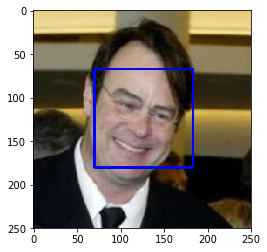

In [2]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

def face_plot(file_path, cascade_algorithm):
    # Read the input image
    img = cv2.imread(file_path)
    # Convert into grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Detect faces
    faces = eval(str(cascade_algorithm + '.detectMultiScale(gray)'))
    
    # print number of faces detected in the image
    print('Number of faces detected:', len(faces))

    # Draw rectangle around the faces
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # display the image, along with bounding box
    plt.imshow(cv_rgb)
    plt.show()

file_path = human_files[0]
face_plot(file_path, "face_cascade")

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Human Face Detector

This procedure is used to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [3]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

Use the code cell below tests the performance of the `face_detector` function by displaying the following: 
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally 100% of human images and 0% of dog images would be detected with a detected face.  The algorithm falls short of this goal, but still gives acceptable performance.  The file paths for the first 100 images from each of the datasets are extracted and stored in the numpy arrays `human_files_short` and `dog_files_short`.

In [4]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

## Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

human_short_len = len(human_files_short)
dog_short_len = len(dog_files_short)

def human_dog_count(detector, model_type = ""): 
    
    # model_type is an optional parameter if detector function requires a pre-trained model
    if model_type != "":
        model_type = class_name(model_type)
    
    human_count = sum([eval(detector+'(human_files_short[i],'+model_type+')') 
                       for i in range(human_short_len)])/human_short_len*100
    print(detector + ': True for {0}% of human_files_short images.'.format(human_count))

    dog_count = sum([eval(detector+'(dog_files_short[i],'+model_type+')')  
                     for i in range(dog_short_len)])/dog_short_len*100
    print(detector + ': True for {0}% of dog_files_short images.'.format(dog_count))

human_dog_count('face_detector')

face_detector: True for 98.0% of human_files_short images.
face_detector: True for 17.0% of dog_files_short images.


For comparison, a default haar cascade designed by OpenCV is tested.

Perfomance of the default haar cascade to detect the frontal face is much worse on non-human images. It detects faces on 61% of the dog images and does not tell the difference between dog and human faces. 

True
Number of faces detected: 1


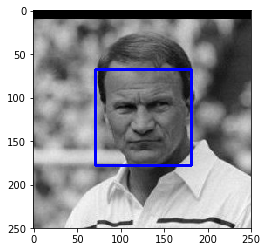

face_detector_OpenCV: True for 99.0% of human_files_short images.
face_detector_OpenCV: True for 61.0% of dog_files_short images.


In [5]:
### Test performance of anotherface detection algorithm.

# Load default haar cascade designed by OpenCV
face_cascade_OpenCV = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')

def face_detector_OpenCV(file_path):
    # Read the input image
    img = cv2.imread(file_path)
    # Convert into grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Detect faces
    faces = face_cascade_OpenCV.detectMultiScale(gray)
    return len(faces) > 0

# Test the algorithm
file_path = human_files[4]

print(face_detector_OpenCV(file_path))
face_plot(file_path, 'face_cascade_OpenCV')

# report performance on human_files_short and dog_files_short
human_dog_count('face_detector_OpenCV')

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images is incorporated.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

The performance of other pre-trained networks is also tested. Therefore, the following additional models are downloaded: [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3) and [densenet121](https://pytorch.org/docs/master/torchvision/models.html#torchvision.models.densenet201).

In [6]:
import torch
import torchvision.models as models

def class_name(class_instance):
    return class_instance.__class__.__name__

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)
type(VGG16).__name__ = "VGG16"

# define densenet121 model
densenet121 = models.densenet121(pretrained=True)
type(densenet121).__name__ = "densenet121"

# define inception_v3 model
inception_v3 = models.inception_v3(pretrained=True)
type(inception_v3).__name__ = "inception_v3"

# define resnet50 model
resnet50 = models.resnet50(pretrained=True)
type(resnet50).__name__ = "resnet50"

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()
    densenet121 = densenet121.cuda()
    inception_v3 = inception_v3.cuda()
    resnet50 = resnet50.cuda()

pretrained = [VGG16, densenet121, inception_v3, resnet50]

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


### Predictions with a Pre-trained Model

In the next code cell, a function is defined that accepts a path to an image as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output is an integer between 0 and 999, inclusive.

In [7]:
from PIL import Image
import torchvision.transforms as transforms
import torch.nn.functional as F

# Get all the classes in ImageNet library
with open('imagenet1000_clsidx_to_labels.txt', 'r') as f:
    imagenet_classes = f.readlines()

max_size = 400
    
def pretrained_predict(img_path, model_type):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image

    image = Image.open(img_path).convert('RGB')

    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if class_name(model_type) == 'inception_v3':
        size = 299
        crop = 299
    else:
        crop = 224
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.CenterCrop(crop), 
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    # set the model in evaluation mode
    model_type.eval()
    
    # move image tensor to cuda if available
    if use_cuda:
        image = image.cuda()
    
    # speed up the by turning off gradients as we're not updating our parameters 
    with torch.no_grad(): 
        output = model_type(image)
    
    # Find class of the highest probability by applying softmax
    classProbab = F.softmax(output, 1)
    
    # ps.topk method to return a tuple of the top-k values and the top-k indices
    top_prob, top_class = classProbab.topk(1, dim=1)
    
    return float(top_prob), int(top_class) # predicted class index as int

# Test the prediction
testFile = dog_files[1]
model_type = pretrained[0]
probability, index = pretrained_predict(testFile, pretrained[0])
print('{0} model: testFile class index: {1}, probability: {2}, class: {3}'.
      format(class_name(model_type), index, round(probability, 2), imagenet_classes[index]))

VGG16 model: testFile class index: 243, probability: 0.86, class:  243: 'bull mastiff',



### Dog Detector Function

The categories given in the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a) corresponding to dogs appear in an uninterrupted sequence with dictionary keys 151-268 inclusive. This includes all categories from `'Chihuahua'` to `'Mexican hairless'`. Thus, if the pre-trained model predicts an index between 151 and 268 (inclusive), an image is predicted to contain a dog by the pre-trained VGG-16 model

This is incorporated in the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [8]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path, model_type):
    return 151 <= pretrained_predict(img_path, model_type)[1] <= 268 # true/false

### Assess the Dog Detector

The code cell below tests the performance of the `dog_detector` function on `human_files_short` and `dog_files_short` files.

All the pretrained models (VGG16, densenet121, inception_v3 and resnet50) have similar performance and error varying from 0% to 2%. In general inception_v3 exhibits the best accuracy for this task. However, VGG16 is used in the remaining part of this notebook.

In [9]:
human_short_len = len(human_files_short)
dog_short_len = len(dog_files_short)

for j in pretrained:
    print('{0} model:'.format(class_name(j)))
    human_dog_count('dog_detector', model_type = j)

VGG16 model:
dog_detector: True for 1.0% of human_files_short images.
dog_detector: True for 99.0% of dog_files_short images.
densenet121 model:
dog_detector: True for 0.0% of human_files_short images.
dog_detector: True for 98.0% of dog_files_short images.
inception_v3 model:
dog_detector: True for 1.0% of human_files_short images.
dog_detector: True for 100.0% of dog_files_short images.
resnet50 model:
dog_detector: True for 0.0% of human_files_short images.
dog_detector: True for 98.0% of dog_files_short images.


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, a CNN that classifies dog breeds is created.  The CNN model _from scratch_ doesn't use transfer (which is used in Step 4 to improv accuracy). 

Please note, that the task of assigning breed to dogs from images is considered exceptionally challenging.  For example, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

Random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

### Specify Data Loaders for the Dog Dataset

The code cell below creates three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).

Train and validation sets are resized to 256, randomly flipped and rotated up to 20 degrees. Next, all data sets are cropped to 224 x 224 size images, similarly to other pretrained models available in `torchvision.models` module. Finally, the images are transformed to tensors and their channels are normalised with means of `[0.485, 0.456, 0.406]` and standard deviations of `[0.229, 0.224, 0.225]`.

In [10]:
import os
from torchvision import datasets
import os

# Create training and test dataloaders

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32
# resize the picture
size = 256

data_transform_train = transforms.Compose([
                transforms.RandomHorizontalFlip(), # randomly flip and rotate
                transforms.RandomRotation(20),
                transforms.Resize(size),
                transforms.CenterCrop(224), 
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), 
                                     (0.229, 0.224, 0.225))]) 
    
data_transform_test = transforms.Compose([
                    transforms.Resize(size),
                    transforms.CenterCrop(224), 
                    transforms.ToTensor(),
                    transforms.Normalize((0.485, 0.456, 0.406), 
                                         (0.229, 0.224, 0.225))]) 

dog_image_dir = '/data/dog_images'

# choose the training and test datasets
train_data = datasets.ImageFolder(dog_image_dir+'/train/', transform=data_transform_train)
valid_data = datasets.ImageFolder(dog_image_dir+'/valid/', transform=data_transform_train)
test_data = datasets.ImageFolder(dog_image_dir+'/test/', transform=data_transform_test)

# class label names
folder_names = [f for f in sorted(os.listdir(dog_image_dir+'/train/'))]
class_names = [item[4:].replace("_", " ") for item in train_data.classes]

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
loaders_scratch = dict(train=train_loader,
                       valid=valid_loader,
                       test=test_loader)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num validation images: ', len(valid_data))
print('Num test images: ', len(test_data))

Num training images:  6680
Num validation images:  835
Num test images:  836


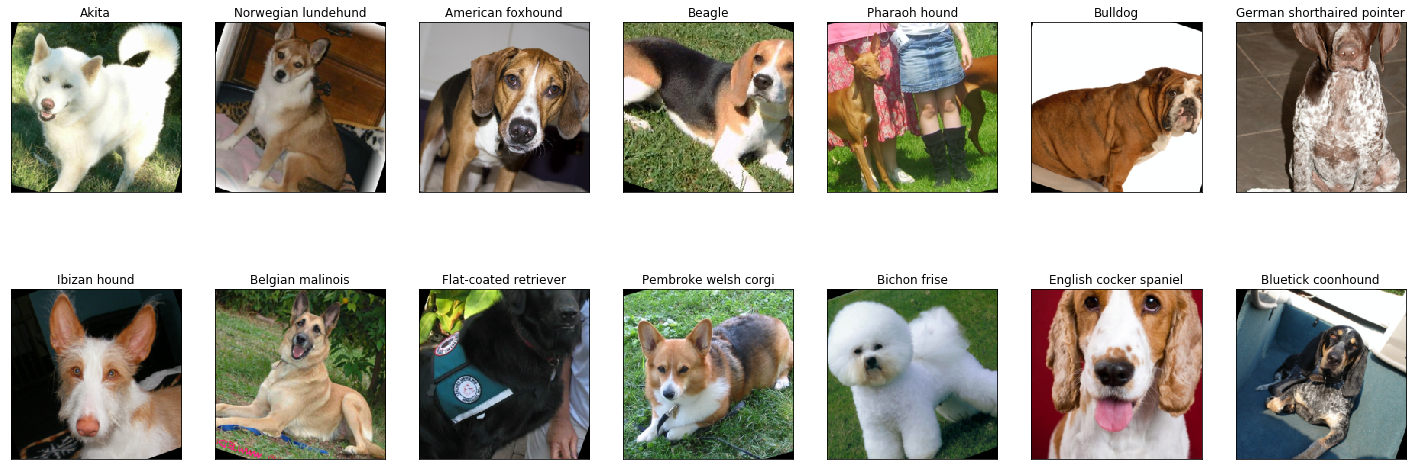

In [11]:
# Visualize some sample train data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# denormalize the image
def denormalise(image):
    image = np.transpose(image, (1, 2, 0))
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = (image * std + mean).clip(0, 1)
    return image

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 9))
no_vis_imag = 14
for idx in np.arange(no_vis_imag):
    ax = fig.add_subplot(2, no_vis_imag/2, idx+1, xticks=[], yticks=[])
    plt.imshow(denormalise(images[idx]))
    ax.set_title(class_names[labels[idx]])

### Model Architecture

Here the CNN architecture to classify dog breed is defined.

In [12]:
import torch.nn as nn
import torch.nn.functional as F

no_labels = len(class_names)

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        # convolutional layer (224x224x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (112x112x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (56x56x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 28 * 28 -> 500)
        self.fc1 = nn.Linear(64 * 28 * 28, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, no_labels)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x))) # 3,224,224  ->  16,224,224  ->  16,112,112
        x = self.pool(F.relu(self.conv2(x))) # 16,112,112  ->  32,112,112  ->  32,56,56
        x = self.pool(F.relu(self.conv3(x))) # 32,56,56  ->  64,56,56  ->  64,28,28
        # flatten image input
        x = x.view(-1, 64 * 28 * 28)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# instantiate the CNN
model_scratch = Net()
print(model_scratch)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=133, bias=True)
  (dropout): Dropout(p=0.25)
)


### Specify Loss Function and Optimizer

The next code cell defines a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html). The chosen loss function is saved as `criterion_scratch`, and the optimizer as `optimizer_scratch`.

In [13]:
import torch.optim as optim

### select loss function
criterion_scratch = nn.CrossEntropyLoss()

### select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01, momentum=0.9)

### Train and Validate the Model

Train and validate the model in the code cell below.  [The final model parameters are saved](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [14]:
## Weights - Normal Distribution
def weights_init_normal(m):
    '''Takes in a module and initializes all linear layers with weight
       values taken from a normal distribution.'''
    
    classname = m.__class__.__name__
    # for every Linear layer in a model
    # m.weight.data shoud be taken from a normal distribution
    # m.bias.data should be 0
    
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

# model with the rule-based, NORMAL weights
model_scratch.apply(weights_init_normal)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=133, bias=True)
  (dropout): Dropout(p=0.25)
)

In [15]:
# Save and load information about the validation progress in info_path (file_name.info)
def save_valid_info(valid_info, save_path):
    info_path = save_path[:-3] + '.info' # save_path = 'file_name.pt'
    np.savetxt(info_path, valid_info, delimiter=',')  

def load_valid_info(save_path):
    info_path = save_path[:-3] + '.info' # save_path = 'file_name.pt'
    info_file = np.loadtxt(info_path, delimiter=',')
    print('loaded validation parameters: valid_loss_min = {0}, valid_epoch_update = {1}, current_lr = {2}'.
          format(info_file[0], int(info_file[1]), info_file[2]))
    return info_file

# Save and load the model
def save_load_model(save_model, load_model, save_path, model):
    if save_model:
        torch.save(model.state_dict(), save_path)
        print('Successfully saved model as {0}'.format(save_path))
        print("model: \n\n", model, '\n')
        print("The state dict keys: \n\n", model.state_dict().keys())

    if load_model:
        state_dict = torch.load(save_path)
        model.load_state_dict(state_dict)
        print('Successfully loaded {0} from {1}'.format(save_path,save_path))
        print("model: \n\n", model_scratch, '\n')
        print("The state dict keys: \n\n", model.state_dict().keys())

save_model = False
load_model = False
save_path = 'model_scratch.pt'
save_load_model(save_model, load_model, save_path, model_scratch)

In [16]:
def adjust_learning_rate(optimizer, decay_factor):
    """Decays the learning rate"""
    
    for param_group in optimizer.param_groups:
        initial_lr = param_group['lr']
        new_lr = initial_lr/decay_factor
        param_group['lr'] = new_lr
        print('learning rate updated from {0} to {1}'.format(initial_lr, new_lr))

def train_parameters (optimizer, save_path):
    """returns trackers for minimum validation loss, validation update epoch, learning rate"""
    
    # See if there is stored information about this model to resume the analysis
    if load_model and os.path.isfile(save_path[:-3] + '.info'): 
        valid_loss_min, valid_epoch_update, current_lr = load_valid_info(save_path)
        valid_epoch_update = int(valid_epoch_update)
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr
        print('restart the analysis from epoch {0}'.format(valid_epoch_update))
    
    # If no stored information about the model do the following initialize all the parameters
    else: 
        #initialize 
        valid_loss_min = np.Inf
        valid_epoch_update = int(0)
        for param_group in optimizer.param_groups:
            current_lr = param_group['lr']
        print('starting learning rate: {0}'.format(current_lr))
    
    return valid_loss_min, valid_epoch_update, current_lr

In [17]:
from PIL import ImageFile
from workspace_utils import active_session

ImageFile.LOAD_TRUNCATED_IMAGES = True
        
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model with the possibility to resume analysis and load validation parameters"""

    valid_loss_min, valid_epoch_update, current_lr = train_parameters(optimizer, save_path)
    valid_unsuccessful_iteration = 0
    
    # keep long session active
    with active_session():
        for epoch in range(valid_epoch_update + 1, n_epochs+1):
            # initialize variables to monitor training and validation loss
            train_loss = 0.0
            valid_loss = 0.0

            ###################
            # train the model #
            ###################
            # set model to train mode by using dropout to prevent overfitting
            model.train()
            for batch_idx, (data, target) in enumerate(loaders['train']):
                # move to GPU
                if use_cuda:
                    data, target = data.cuda(), target.cuda()

                ## find the loss and update the model parameters accordingly

                # clear the gradients of all optimized variables
                optimizer.zero_grad()
                # forward pass: compute predicted outputs by passing inputs to the model
                output = model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # backward pass: compute gradient of the loss with respect to model parameters
                loss.backward()
                # perform a single optimization step (parameter update)
                optimizer.step()
                # update training loss
                #train_loss += loss.item()*data.size(0)
                train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))

            ######################    
            # validate the model #
            ######################
            model.eval()
            for batch_idx, (data, target) in enumerate(loaders['valid']):
                # move to GPU
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                ## update the average validation loss
                # forward pass: compute predicted outputs by passing inputs to the model
                output = model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # update average validation loss 
                valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            # print training/validation statistics 
            print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
                epoch, 
                train_loss,
                valid_loss
                ))

            ## save the model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
                torch.save(model.state_dict(), save_path)
                valid_loss_min = valid_loss
                # update/reset trackers and store information about the validation progress
                valid_epoch_update = epoch
                valid_info = [valid_loss_min, valid_epoch_update, current_lr]
                save_valid_info(valid_info, save_path) 
                valid_unsuccessful_iteration = 0
            
            # Keep track of unsuccessful validation updates
            else: 
                valid_unsuccessful_iteration += 1
                #Update learning rate after a few consecutive unsuccessful iterations
                if valid_unsuccessful_iteration == 5:
                    decay_factor = 2
                    adjust_learning_rate(optimizer, decay_factor)
                    current_lr /= decay_factor
                    valid_unsuccessful_iteration = 0
                       
    # return trained model
    return model

# train the model
n_epoch = 20
model_scratch = train(n_epoch, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

starting learning rate: 0.01
Epoch: 1 	Training Loss: 4.798426 	Validation Loss: 4.644074
Validation loss decreased (inf --> 4.644074).  Saving model ...
Epoch: 2 	Training Loss: 4.496092 	Validation Loss: 4.548998
Validation loss decreased (4.644074 --> 4.548998).  Saving model ...
Epoch: 3 	Training Loss: 4.344267 	Validation Loss: 4.285249
Validation loss decreased (4.548998 --> 4.285249).  Saving model ...
Epoch: 4 	Training Loss: 4.204512 	Validation Loss: 4.259275
Validation loss decreased (4.285249 --> 4.259275).  Saving model ...
Epoch: 5 	Training Loss: 4.077898 	Validation Loss: 4.137149
Validation loss decreased (4.259275 --> 4.137149).  Saving model ...
Epoch: 6 	Training Loss: 3.926354 	Validation Loss: 4.067796
Validation loss decreased (4.137149 --> 4.067796).  Saving model ...
Epoch: 7 	Training Loss: 3.790732 	Validation Loss: 4.030324
Validation loss decreased (4.067796 --> 4.030324).  Saving model ...
Epoch: 8 	Training Loss: 3.675508 	Validation Loss: 4.008214
Valid

#### CNN architecture reasoning

The architecture is defined as follows:
```python
#Flatten input image
x = x.view(-1, 64 * 28 * 28) # 3,224,224

# First convolutional layer, ReLU activation function, MaxPooling layer
x = F.relu(self.conv1(x)) # 3,224,224  ->  16,224,224 
x = self.pool(x) # 16,224,224  ->  16,112,112

#Second convolutional layer, ReLU activation function, MaxPooling layer
x = F.relu(self.conv2(x)) # 16,112,112  ->  32,112,112
x = self.pool(x) # 32,112,112  ->  32,56,56

#Third convolutional layer, ReLU activation function, MaxPooling layer
x = F.relu(self.conv3(x)) # 32,56,56  ->  64,56,56
x = self.pool(x) # 64,56,56  ->  64,28,28

#First fully connected layer and dropout to prevent overfitting
x = self.dropout(x)
x = F.relu(self.fc1(x)) # 50176 -> 500

#Second fully connected layer and dropout 
x = self.dropout(x)
x = F.relu(self.fc2(x)) # 500 -> 133 (there are 133 classes)
```
Linear layers are initialized with a uniform distribution of weights and biases using `weights_init_normal` function.

During the analysis, each succesful validation reduction saves the model as `model.pt`, along with its parameters (epoch, valid loss and learning rate) as `model.info`. Hence, the analysis can be interrupted at any point if GPU/CPU needs to be disabled and reinstated using `save_load_model` function.

After epoch 14 the model did not update any further. It is likely that the algorithm got stuck in the local minima, despite using a momentum factor of 0.9. Potentially, incorporating additional convolutional layers could improve the performance.

### Test the Model

Try out the model on the test dataset of dog images. The code cell below calculates and prints the test loss and accuracy.

In [18]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    #for batch_idx, (data, target) in enumerate(loaders['test']):
    for batch_idx, (data, target) in enumerate(test_loader):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 4.192331


Test Accuracy: 16% (138/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

Use transfer learning to create a CNN that can identify dog breed from images.

### Specify Data Loaders for the Dog Dataset

Use the same data loaders from the previous step.

In [19]:
# Use the same loaders
loaders_transfer = loaders_scratch

### Model Architecture

The code cell below creates the CNN model and saves the initialized model as the variable `model_transfer`.

VGG16 is used with all the convolutional layers obtained from the pretrained model.The final fully-connected layer is replaced with a new classifier, to match the existing dog breed classes.

In [20]:
import torchvision.models as models
import torch.nn as nn

## Specify model architecture 

# Use defined before VGG16 model
model_transfer = VGG16

n_inputs = model_transfer.classifier[6].in_features
last_layer = nn.Linear(n_inputs, no_labels)

model_transfer.classifier[6] = last_layer

# check to see that your last layer produces the expected number of outputs
print('Length of last year equal to the number of classes: {0}'.
      format(model_transfer.classifier[6].out_features == len(class_names)))

if use_cuda:
    model_transfer = model_transfer.cuda()

Length of last year equal to the number of classes: True


### Specify Loss Function and Optimizer

The next code cell specifies a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html). The chosen loss function is saved as `criterion_transfer`, and the optimizer as `optimizer_transfer`.

In [21]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.parameters(), lr=0.01)

### Train and Validate the Model

Train and validate the model in the code cell below.  [The final model parameters are saved](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [22]:
# Save/load the model

save_model = False
load_model = False
save_path = 'model_transfer.pt'
save_load_model(save_model, load_model, save_path, model_scratch)

In [23]:
# train the model
n_epochs = 6
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

starting learning rate: 0.01
Epoch: 1 	Training Loss: 1.862304 	Validation Loss: 0.862319
Validation loss decreased (inf --> 0.862319).  Saving model ...
Epoch: 2 	Training Loss: 0.858790 	Validation Loss: 0.820753
Validation loss decreased (0.862319 --> 0.820753).  Saving model ...
Epoch: 3 	Training Loss: 0.620937 	Validation Loss: 0.628004
Validation loss decreased (0.820753 --> 0.628004).  Saving model ...
Epoch: 4 	Training Loss: 0.504246 	Validation Loss: 0.645472
Epoch: 5 	Training Loss: 0.409992 	Validation Loss: 0.528801
Validation loss decreased (0.628004 --> 0.528801).  Saving model ...
Epoch: 6 	Training Loss: 0.364262 	Validation Loss: 0.568818


### Test the Model

Test the model on the test dataset of dog images. The code cell below calculates and prints the test loss and accuracy.

In [25]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.500703


Test Accuracy: 85% (718/836)


### Predict Dog Breed with the Model

The function below takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by the model.  

In [27]:
### Function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    
    image = Image.open(img_path).convert('RGB')
    max_size = 400

    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.CenterCrop(224), 
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)

    # move image tensor to cuda if available
    if use_cuda:
        image = image.cuda()

    # speed up the by turning off gradients as we're not updating our parameters 
    with torch.no_grad(): 
        output = model_transfer(image)

    # Find class of the highest probability by applying softmax
    classProbab = F.softmax(output, 1)

    # ps.topk method to return a tuple of the top-k values and the top-k indices
    top_probs, top_classes = classProbab.topk(5, dim=1)
    top_probs = np.array(top_probs).ravel() 
    top_classes = np.array(top_classes).ravel()
    
    return top_probs, top_classes

---
<a id='step5'></a>
## Step 5: Create the Algorithm

An algorithm is written, that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  

In [28]:
def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    
    is_human = face_detector(img_path)
    is_dog = dog_detector(img_path, pretrained[1])
    top_probs, top_classes = predict_breed_transfer(img_path)
    
    top_class_lbls = [class_names[i] for i in top_classes]
    
    if is_human:
        title = 'Hello human!'
    if is_dog:
        title = 'Hello doggie!'
    if is_human and is_dog:
        title = 'Hello human and doggie!'
    if not(is_human or is_dog):
        title = 'Hello, I am not sure who you are.'
        
    # show image
    fig, (ax1, ax2) = plt.subplots(figsize=(15,5), ncols=2)  
    image = Image.open(img_path).convert('RGB')
    ax1.imshow(image)
    ax1.set_yticks([])
    ax1.set_xticks([])
    
    caption = 'You are {0:.2f}% likely to be a {1}'.format(top_probs[0]*100, top_class_lbls[0])
    ax1.set_xlabel(caption)
    ax1.set_title(title)
    
    y_pos = np.arange(len(top_classes))

    ax2.barh(y_pos, top_probs, align='center', alpha=0.5)
    plt.yticks(y_pos, top_class_lbls)
    ax2.set_xlabel('Class probability')
    ax2.set_title('Dog breeds')
    plt.tight_layout()

---
<a id='step6'></a>
## Step 6: Test the Algorithm

In this section, the algorithm is tested on different images.

### Dog pictures

First, test the model on the pictures from the dogs dataset and compare the results against their labels.

Correct! This is a Mastiff
Correct! This is a Doberman pinscher
Correct! This is a Doberman pinscher


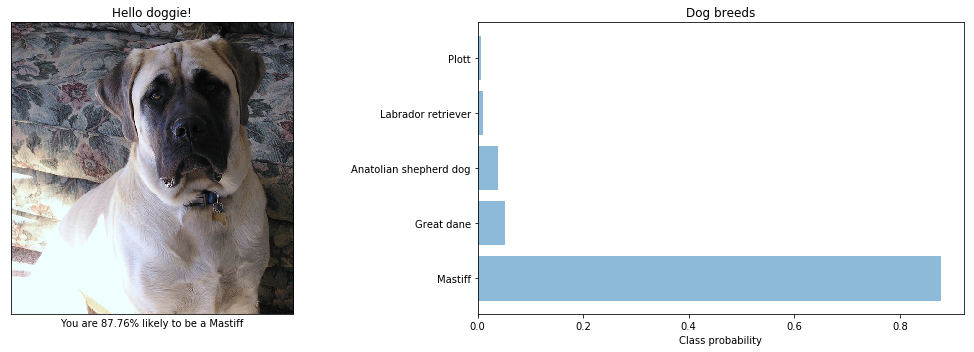

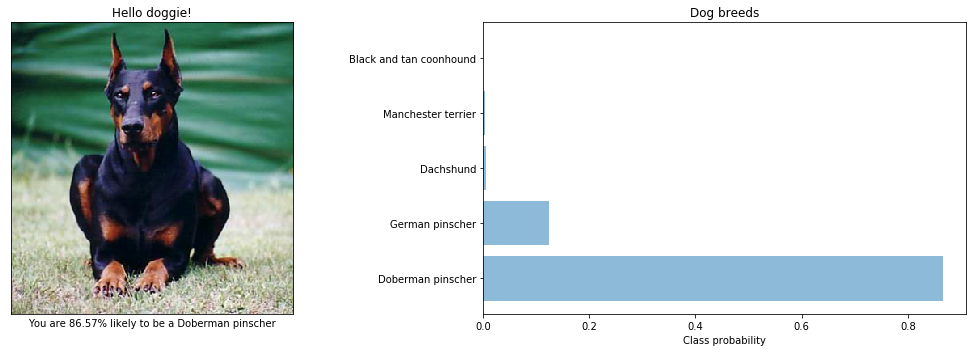

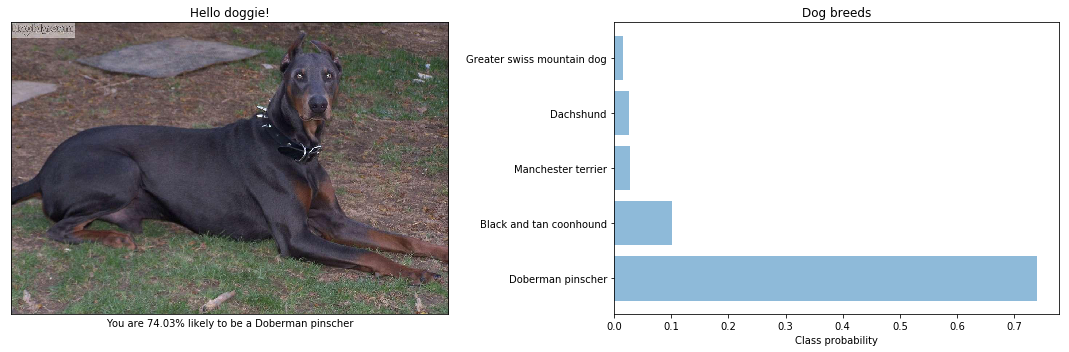

In [30]:
from pathlib import Path
import random 

def dog_path2class(file_path):
    path = Path(file_path)
    dog_label = int(str(path.parts[-2]).split(".")[0])-1
    top_probs, top_classes = predict_breed_transfer(file_path)
    correct_precition = top_classes[0] == dog_label
    if correct_precition:
        print('Correct! This is a {0}'.format(class_names[dog_label]))
    else:
        print('Incorrect! This should be a {0}'.format(class_names[dog_label]))

for i in range(3):
    file = dog_files[random.randrange(len(class_names))]
    run_app(file)
    dog_path2class(file)

### Human pictures

What about the performance of the model on the human database?

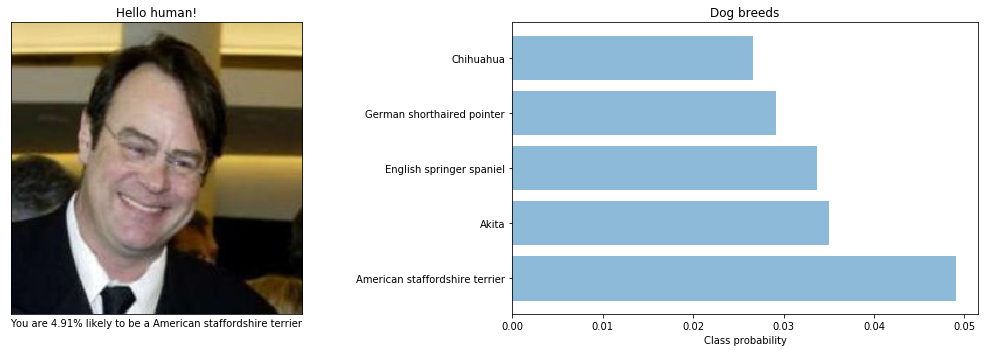

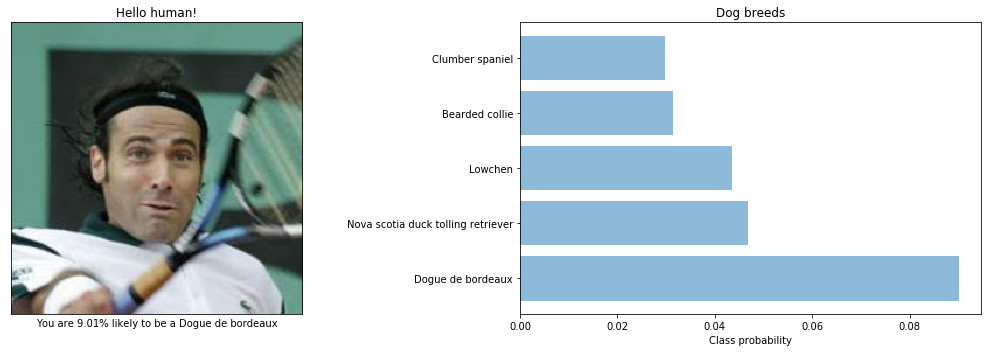

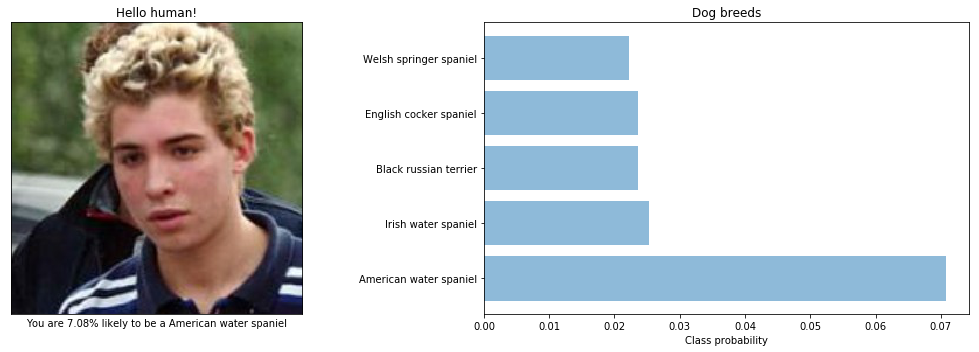

In [31]:
for file in np.hstack((human_files[:3])):
    run_app(file)

### Let's further test the model 

The model has been tested on the images from the original human and dogs database. Next, let's try some random pictures and other animals. I have some from my time when volunteering at the elephant sanctuary in Phetchaburi, Thailand.

First, let's test this picture of a gator that was adopted by the foundation.

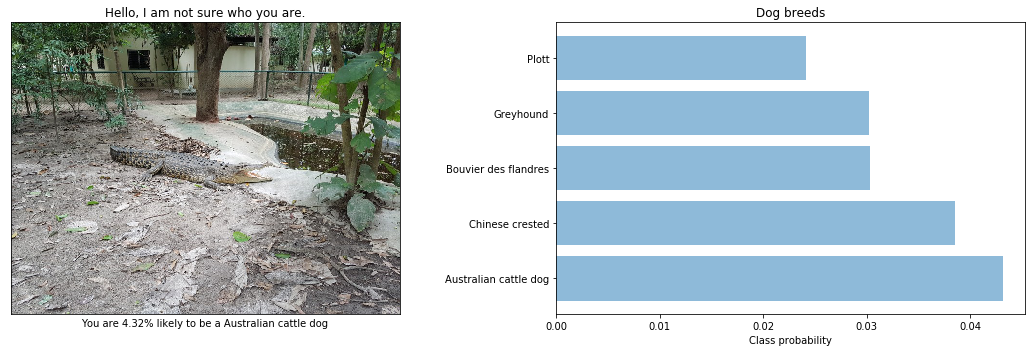

In [32]:
run_app(os. getcwd() + "/images/test/gator.jpg")

This is <span style="color:green">correct</span>, there are neither humans or dogs!

How about a picture of me taking Thong Ma the elephant for a walk?

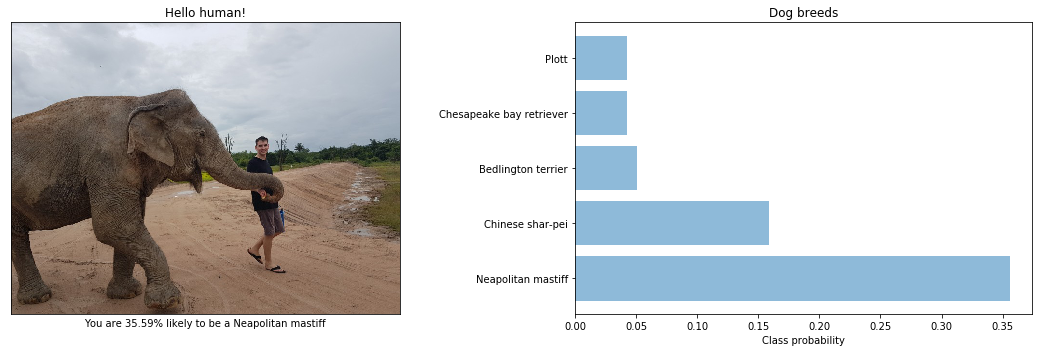

In [33]:
run_app(os. getcwd() + "/images/test/elephant1.jpg")

Again, face detector <span style="color:green">correctly</span> recognised a human in the picture. But the dog breed classifier implies that there might be a Neapolitan Mastiff. This could be worth investigating further.

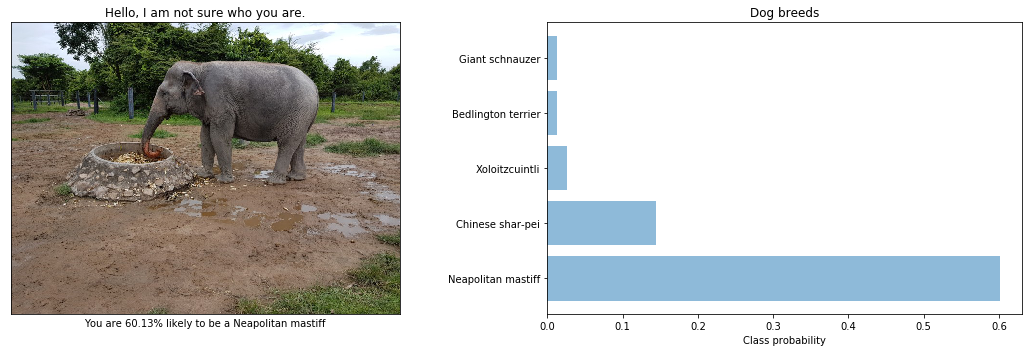

In [34]:
run_app(os. getcwd() + "/images/test/elephant2.jpg")

In this picture above of an elephant, the algorithm <span style="color:green">correctly</span> tells that there is neither a human nor a dog. Its probable breed is again a Neapolitan Mastiff.

A quick reminder of how this dog breed looks like gives some indication what could be the reason for that. The algorithm might recognise Neapolitan Mastiff based on its floppy ears and loose skin. 

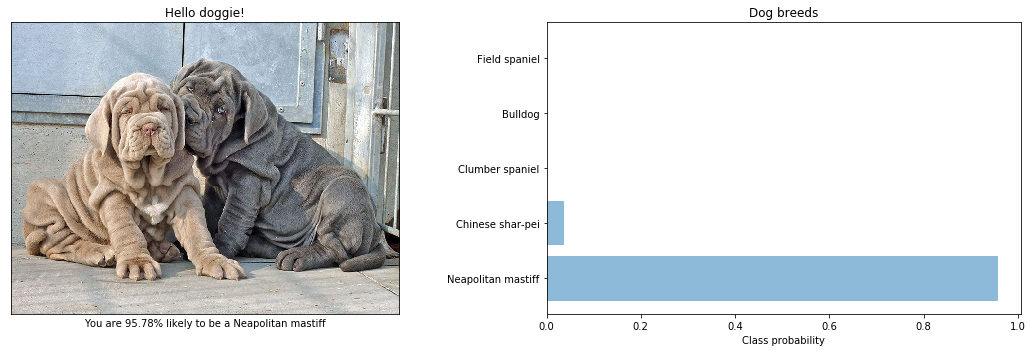

In [35]:
run_app(os. getcwd() + "/images/test/neapolitan_mastiff.jpg")

Humans and dogs are recognised simultaneously in both pictures below.

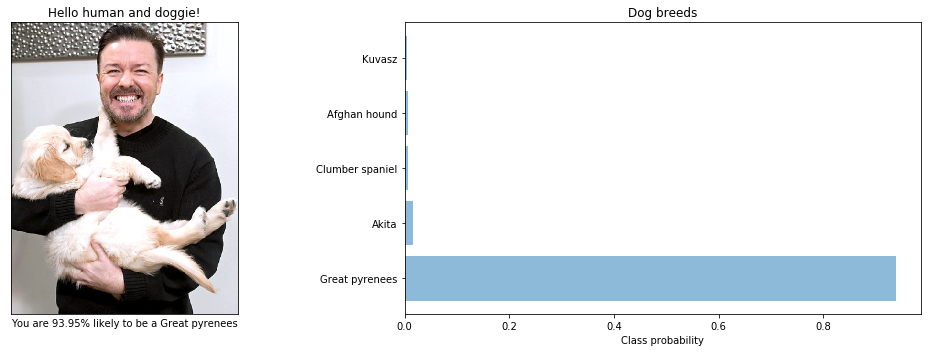

In [57]:
run_app(os. getcwd() + "/images/test/dog_human1.png")

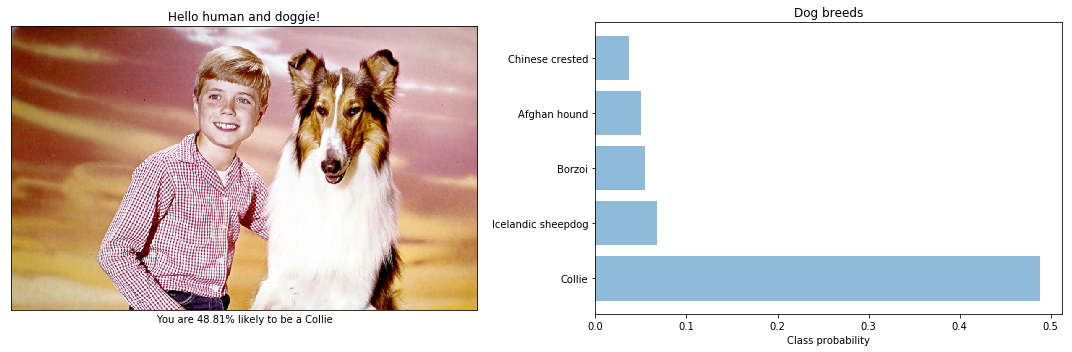

In [58]:
run_app(os. getcwd() + "/images/test/dog_human2.png")

I can't help myself but check what breed Pluto will be. Officially it's a mixed-breed dog, but he was introduced in <em>The Chain Gang</em> episode of Mickey Mouse in 1930 as a bloodhound.

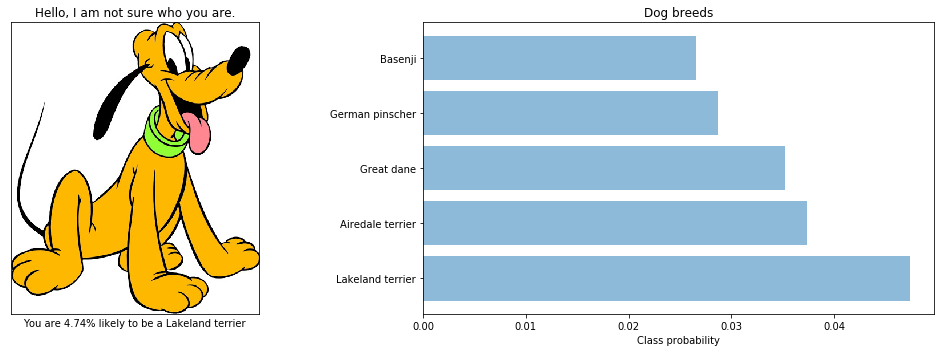

In [59]:
run_app(os. getcwd() + "/images/test/Pluto.jpg")

Since I'm more of a cat person, let's see what the model predicts on the picture of my cat.

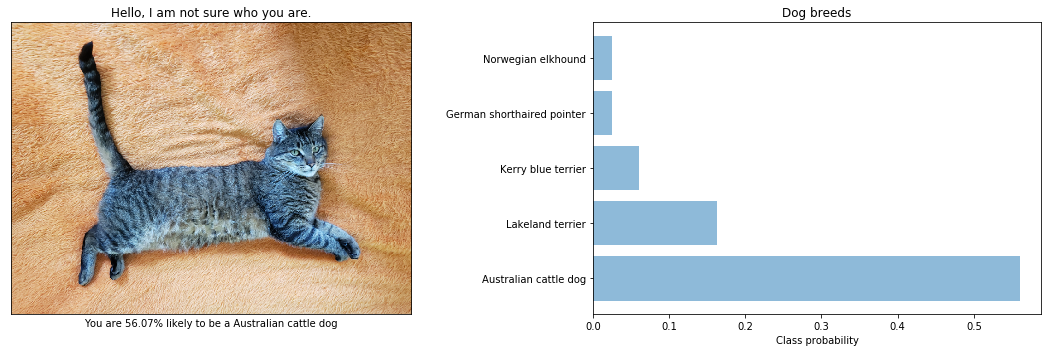

In [61]:
run_app(os. getcwd() + "/images/test/cat.png")

Finally, let's test the model on my own selfie.

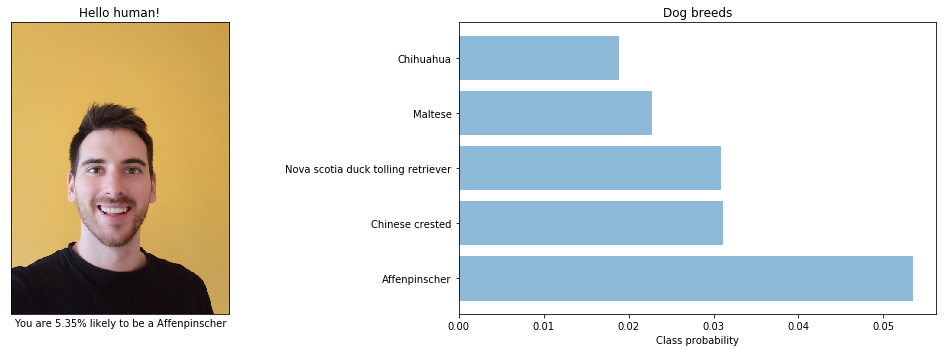

In [63]:
run_app(os. getcwd() + "/images/test/human1.png")

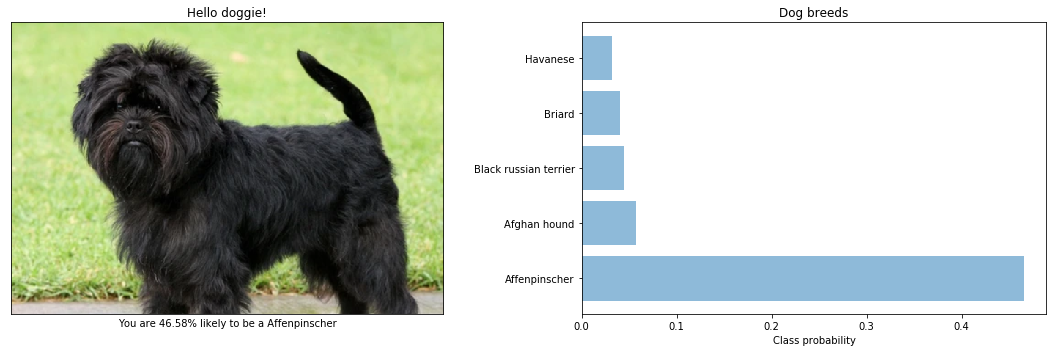

In [65]:
run_app(os. getcwd() + "/images/test/Affenpinscher.png")

### Algorithm Efficiency

The efficiency of 85% seems like a significant improvement, compared to 16% trained on a simple CCN defined in step 3. The algorithm most of the time can identify humans and dogs, which is implied in the title when printed. 

The app quite well predicts dog breeds, not only on the images from the database but also other ones. However, when pictures of other animals or objects are tested, odd probabilities can be returned. This was shown for the two elephant pictures, which resulted in up to 60% likelihood to be a Neapolitan Mastiff. The picture of an actual Neapolitan Mastiff gave 96% probability to be that breed. Potentially the algorithm might overfit for certain classes.

The following improvements are suggested:
* Include other classes of animals in data loader, so that the algorithm doesn't mistake animals with similar features e.g. Neapolitan Mastiff with elephants.
* Increase the number of epochs. The last succesful model was saved after the fifth epoch, potentially extending this might result in better performance. On the other hand, there is a risk of overfitting if the train loss drop much lower than the validation loss.
* Extend the library of dog breeds. Notice that there are 13233 human images, whilst only 8351 dog images. This gives only 63 pictures on average per class.